In [ ]:
# Cell 1: Setup and Installation
print("="*70)
print("TRAFFIC ACCIDENT PREDICTION PIPELINE")
print("Complete Data Engineering & ML Project")
print("="*70)

TRAFFIC ACCIDENT PREDICTION PIPELINE
Complete Data Engineering & ML Project


In [ ]:
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("\n✓ All packages installed successfully!")
print("\nStarting Pipeline Execution...\n")


✓ All packages installed successfully!

Starting Pipeline Execution...



In [ ]:

print("="*70)
print("PHASE 1: DATA GENERATION & INGESTION")
print("="*70)

class TrafficDataGenerator:
    """Generate synthetic traffic accident data"""

    def __init__(self, n_records=10000):
        self.n_records = n_records
        np.random.seed(42)

    def generate_data(self):
        """Generate comprehensive traffic data"""
        print(f"\n📊 Generating {self.n_records} traffic records...")

        # Base datetime
        start_date = datetime(2023, 1, 1)

        data = {
            'record_id': [f'REC_{i:06d}' for i in range(self.n_records)],
            'timestamp': [start_date + timedelta(hours=np.random.randint(0, 8760))
                         for _ in range(self.n_records)],
            'location_id': [f'LOC_{np.random.randint(1, 101):03d}'
                           for _ in range(self.n_records)],
            'latitude': np.random.uniform(12.9, 13.1, self.n_records),
            'longitude': np.random.uniform(77.5, 77.7, self.n_records),
            'weather': np.random.choice(['Clear', 'Rain', 'Fog', 'Snow', 'Cloudy'],
                                       self.n_records, p=[0.5, 0.2, 0.1, 0.05, 0.15]),
            'temperature': np.random.normal(25, 8, self.n_records),
            'visibility': np.random.randint(0, 101, self.n_records),
            'road_type': np.random.choice(['Highway', 'Urban', 'Rural', 'Residential'],
                                         self.n_records, p=[0.3, 0.4, 0.2, 0.1]),
            'traffic_volume': np.random.randint(0, 101, self.n_records),
            'speed_limit': np.random.choice([30, 40, 50, 60, 70, 80], self.n_records),
            'road_condition': np.random.choice(['Dry', 'Wet', 'Icy', 'Under Construction'],
                                              self.n_records, p=[0.6, 0.25, 0.1, 0.05]),
            'lighting': np.random.choice(['Daylight', 'Dark', 'Dusk/Dawn'],
                                        self.n_records, p=[0.6, 0.3, 0.1]),
            'construction_zone': np.random.choice([0, 1], self.n_records, p=[0.9, 0.1]),
            'school_zone': np.random.choice([0, 1], self.n_records, p=[0.95, 0.05]),
        }

        df = pd.DataFrame(data)

        # Extract time features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['day_of_month'] = df['timestamp'].dt.day

        # Generate accident labels with realistic logic
        df['accident_occurred'] = self._generate_accident_labels(df)

        print(f"✓ Generated {len(df)} records")
        print(f"✓ Accident Rate: {df['accident_occurred'].mean()*100:.2f}%")

        return df

    def _generate_accident_labels(self, df):
        """Generate accident labels based on risk factors"""
        accident_prob = np.zeros(len(df))

        # Base probability
        accident_prob += 0.05

        # Time-based factors
        accident_prob += ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int) * 0.15  # Morning rush
        accident_prob += ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int) * 0.15  # Evening rush
        accident_prob += ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int) * 0.10  # Late night
        accident_prob += (df['day_of_week'] >= 5).astype(int) * 0.05  # Weekends

        # Weather-based factors
        accident_prob += (df['weather'] == 'Rain').astype(int) * 0.20
        accident_prob += (df['weather'] == 'Fog').astype(int) * 0.25
        accident_prob += (df['weather'] == 'Snow').astype(int) * 0.30

        # Visibility
        accident_prob += (df['visibility'] < 30).astype(int) * 0.25
        accident_prob += ((df['visibility'] >= 30) & (df['visibility'] < 60)).astype(int) * 0.15

        # Traffic volume
        accident_prob += (df['traffic_volume'] > 80).astype(int) * 0.20

        # Road conditions
        accident_prob += (df['road_condition'] == 'Wet').astype(int) * 0.15
        accident_prob += (df['road_condition'] == 'Icy').astype(int) * 0.30

        # Speed limit
        accident_prob += (df['speed_limit'] > 60).astype(int) * 0.10

        # Special zones
        accident_prob += (df['construction_zone'] == 1).astype(int) * 0.15

        # Lighting
        accident_prob += (df['lighting'] == 'Dark').astype(int) * 0.15

        # Cap probability
        accident_prob = np.clip(accident_prob, 0, 0.95)

        # Generate binary outcome
        return (np.random.random(len(df)) < accident_prob).astype(int)

# Generate data
generator = TrafficDataGenerator(n_records=10000)
raw_data = generator.generate_data()

print(f"\n📈 Dataset Shape: {raw_data.shape}")
print("\n📋 First few records:")
print(raw_data.head())

# Save raw data (Bronze layer)
raw_data.to_csv('traffic_data_raw.csv', index=False)
print("\n✓ Raw data saved to 'traffic_data_raw.csv'")


PHASE 1: DATA GENERATION & INGESTION

📊 Generating 10000 traffic records...
✓ Generated 10000 records
✓ Accident Rate: 52.89%

📈 Dataset Shape: (10000, 20)

📋 First few records:
    record_id           timestamp location_id   latitude  longitude weather  \
0  REC_000000 2023-10-30 22:00:00     LOC_037  13.097955  77.549757   Clear   
1  REC_000001 2023-02-05 20:00:00     LOC_038  12.960437  77.559586    Rain   
2  REC_000002 2023-08-13 14:00:00     LOC_096  12.955506  77.670494   Clear   
3  REC_000003 2023-08-05 07:00:00     LOC_011  13.072886  77.584015     Fog   
4  REC_000004 2023-08-27 22:00:00     LOC_001  12.900675  77.698113    Rain   

   temperature  visibility    road_type  traffic_volume  speed_limit  \
0    29.700826          18        Rural              24           80   
1    36.943154          70      Highway              64           30   
2    26.487028          88        Urban              28           60   
3    18.385187          93      Highway              31    

In [ ]:
print("\n" + "="*70)
print("PHASE 2: DATA QUALITY CHECKS & VALIDATION")
print("="*70)

class DataQualityChecker:
    """Perform comprehensive data quality checks"""

    def __init__(self, df):
        self.df = df
        self.quality_report = {}

    def run_all_checks(self):
        """Execute all quality checks"""
        print("\n🔍 Running Data Quality Checks...\n")

        self.check_missing_values()
        self.check_duplicates()
        self.check_data_types()
        self.check_value_ranges()
        self.check_categorical_values()

        return self.quality_report

    def check_missing_values(self):
        """Check for missing values"""
        missing = self.df.isnull().sum()
        missing_pct = (missing / len(self.df)) * 100

        print("1️⃣  Missing Values Check:")
        if missing.sum() == 0:
            print("   ✓ No missing values found")
            self.quality_report['missing_values'] = 'PASS'
        else:
            print(f"   ⚠ Found missing values in {missing[missing > 0].shape[0]} columns")
            self.quality_report['missing_values'] = 'FAIL'

    def check_duplicates(self):
        """Check for duplicate records"""
        duplicates = self.df.duplicated().sum()
        print(f"\n2️⃣  Duplicate Records Check:")
        print(f"   Found {duplicates} duplicate records ({duplicates/len(self.df)*100:.2f}%)")
        self.quality_report['duplicates'] = duplicates

    def check_data_types(self):
        """Verify data types"""
        print(f"\n3️⃣  Data Types Check:")
        print(f"   ✓ All columns have appropriate data types")
        self.quality_report['data_types'] = 'PASS'

    def check_value_ranges(self):
        """Check if values are within expected ranges"""
        print(f"\n4️⃣  Value Range Check:")

        checks = {
            'visibility': (0, 100),
            'traffic_volume': (0, 100),
            'hour': (0, 23),
            'day_of_week': (0, 6)
        }

        all_pass = True
        for col, (min_val, max_val) in checks.items():
            if col in self.df.columns:
                out_of_range = ((self.df[col] < min_val) | (self.df[col] > max_val)).sum()
                if out_of_range > 0:
                    print(f"   ⚠ {col}: {out_of_range} values out of range")
                    all_pass = False

        if all_pass:
            print("   ✓ All values within expected ranges")

        self.quality_report['value_ranges'] = 'PASS' if all_pass else 'FAIL'

    def check_categorical_values(self):
        """Check categorical value distributions"""
        print(f"\n5️⃣  Categorical Values Check:")

        categorical_cols = ['weather', 'road_type', 'road_condition', 'lighting']

        for col in categorical_cols:
            if col in self.df.columns:
                unique_vals = self.df[col].nunique()
                print(f"   ✓ {col}: {unique_vals} unique values")

        self.quality_report['categorical'] = 'PASS'

# Run quality checks
quality_checker = DataQualityChecker(raw_data)
quality_report = quality_checker.run_all_checks()

print("\n" + "="*70)
print("QUALITY REPORT SUMMARY")
print("="*70)
for check, result in quality_report.items():
    status = "✓" if result == 'PASS' or result == 0 else "⚠"
    print(f"{status} {check}: {result}")



PHASE 2: DATA QUALITY CHECKS & VALIDATION

🔍 Running Data Quality Checks...

1️⃣  Missing Values Check:
   ✓ No missing values found

2️⃣  Duplicate Records Check:
   Found 0 duplicate records (0.00%)

3️⃣  Data Types Check:
   ✓ All columns have appropriate data types

4️⃣  Value Range Check:
   ✓ All values within expected ranges

5️⃣  Categorical Values Check:
   ✓ weather: 5 unique values
   ✓ road_type: 4 unique values
   ✓ road_condition: 4 unique values
   ✓ lighting: 3 unique values

QUALITY REPORT SUMMARY
✓ missing_values: PASS
✓ duplicates: 0
✓ data_types: PASS
✓ value_ranges: PASS
✓ categorical: PASS


In [ ]:
print("\n" + "="*70)
print("PHASE 3: DATA CLEANING & TRANSFORMATION")
print("="*70)

class DataCleaner:
    """Clean and transform raw data"""

    def __init__(self, df):
        self.df = df.copy()
        self.cleaning_log = []

    def clean_data(self):
        """Execute all cleaning operations"""
        print("\n🧹 Cleaning data...\n")

        initial_shape = self.df.shape

        # Remove duplicates
        before = len(self.df)
        self.df = self.df.drop_duplicates()
        after = len(self.df)
        if before - after > 0:
            self.log_action(f"Removed {before - after} duplicate records")

        # Handle missing values
        self.df = self.df.dropna()

        # Remove outliers
        self.remove_outliers()

        # Standardize categorical values
        self.standardize_categories()

        # Add data quality flags
        self.add_quality_flags()

        final_shape = self.df.shape

        print(f"✓ Cleaning complete")
        print(f"  Initial records: {initial_shape[0]}")
        print(f"  Final records: {final_shape[0]}")
        print(f"  Records removed: {initial_shape[0] - final_shape[0]}")
        print(f"  Data retention: {final_shape[0]/initial_shape[0]*100:.2f}%")

        return self.df

    def remove_outliers(self):
        """Remove statistical outliers"""
        numeric_cols = ['temperature', 'visibility', 'traffic_volume']

        for col in numeric_cols:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR

            before = len(self.df)
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
            after = len(self.df)

            if before - after > 0:
                self.log_action(f"Removed {before - after} outliers from {col}")

    def standardize_categories(self):
        """Standardize categorical values"""

        cat_cols = ['weather', 'road_type', 'road_condition', 'lighting']
        for col in cat_cols:
            if col in self.df.columns:
                self.df[col] = self.df[col].str.title()

    def add_quality_flags(self):
        """Add data quality indicator flags"""
        self.df['data_quality_score'] = 100


        self.df.loc[self.df['visibility'] == 0, 'data_quality_score'] -= 10
        self.df.loc[self.df['traffic_volume'] == 0, 'data_quality_score'] -= 5

    def log_action(self, action):
        """Log cleaning actions"""
        self.cleaning_log.append(action)
        print(f"  • {action}")

# Clean data
cleaner = DataCleaner(raw_data)
cleaned_data = cleaner.clean_data()

# Save cleaned data (Silver layer)
cleaned_data.to_csv('traffic_data_cleaned.csv', index=False)
print("\n✓ Cleaned data saved to 'traffic_data_cleaned.csv'")


PHASE 3: DATA CLEANING & TRANSFORMATION

🧹 Cleaning data...

✓ Cleaning complete
  Initial records: 10000
  Final records: 10000
  Records removed: 0
  Data retention: 100.00%

✓ Cleaned data saved to 'traffic_data_cleaned.csv'


In [ ]:
print("\n" + "="*70)
print("PHASE 4: FEATURE ENGINEERING")
print("="*70)

class FeatureEngineer:
    """Create advanced features for ML"""

    def __init__(self, df):
        self.df = df.copy()
        self.features_created = []

    def engineer_features(self):
        """Create all engineered features"""
        print("\n⚙️  Engineering features...\n")

        self.create_time_features()
        self.create_weather_features()
        self.create_traffic_features()
        self.create_risk_scores()
        self.create_interaction_features()

        print(f"\n✓ Feature engineering complete")
        print(f"  Features created: {len(self.features_created)}")
        print(f"  Total columns: {self.df.shape[1]}")

        return self.df

    def create_time_features(self):
        """Create time-based features"""
        print("1️⃣  Creating time-based features...")

        # Rush hour indicators
        self.df['is_morning_rush'] = ((self.df['hour'] >= 7) & (self.df['hour'] <= 9)).astype(int)
        self.df['is_evening_rush'] = ((self.df['hour'] >= 17) & (self.df['hour'] <= 19)).astype(int)
        self.df['is_rush_hour'] = (self.df['is_morning_rush'] | self.df['is_evening_rush']).astype(int)

        # Time of day
        self.df['is_night'] = ((self.df['hour'] >= 22) | (self.df['hour'] <= 5)).astype(int)
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)

        # Time periods
        self.df['time_period'] = pd.cut(self.df['hour'],
                                        bins=[0, 6, 12, 18, 24],
                                        labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                        include_lowest=True)

        self.features_created.extend(['is_morning_rush', 'is_evening_rush', 'is_rush_hour',
                                     'is_night', 'is_weekend', 'time_period'])
        print("   ✓ Created 6 time-based features")

    def create_weather_features(self):
        """Create weather-related features"""
        print("2️⃣  Creating weather features...")

        # Weather risk
        self.df['weather_risk'] = self.df['weather'].map({
            'Clear': 0, 'Cloudy': 1, 'Rain': 2, 'Fog': 3, 'Snow': 4
        })

        # Adverse weather flag
        self.df['adverse_weather'] = (self.df['weather'].isin(['Rain', 'Fog', 'Snow'])).astype(int)

        # Temperature categories
        self.df['temp_category'] = pd.cut(self.df['temperature'],
                                          bins=[-np.inf, 10, 25, np.inf],
                                          labels=['Cold', 'Moderate', 'Hot'])

        # Visibility categories
        self.df['visibility_category'] = pd.cut(self.df['visibility'],
                                                bins=[0, 30, 60, 100],
                                                labels=['Poor', 'Moderate', 'Good'])

        self.df['low_visibility'] = (self.df['visibility'] < 50).astype(int)

        self.features_created.extend(['weather_risk', 'adverse_weather', 'temp_category',
                                     'visibility_category', 'low_visibility'])
        print("   ✓ Created 5 weather features")

    def create_traffic_features(self):
        """Create traffic-related features"""
        print("3️⃣  Creating traffic features...")

        # Traffic density categories
        self.df['traffic_density'] = pd.cut(self.df['traffic_volume'],
                                           bins=[0, 30, 70, 100],
                                           labels=['Low', 'Medium', 'High'])

        self.df['high_traffic'] = (self.df['traffic_volume'] > 70).astype(int)

        # Speed risk
        self.df['high_speed_zone'] = (self.df['speed_limit'] > 60).astype(int)

        # Road condition risk
        self.df['poor_road_condition'] = (self.df['road_condition'].isin(['Wet', 'Icy'])).astype(int)

        # Urban vs highway
        self.df['is_highway'] = (self.df['road_type'] == 'Highway').astype(int)
        self.df['is_urban'] = (self.df['road_type'] == 'Urban').astype(int)

        self.features_created.extend(['traffic_density', 'high_traffic', 'high_speed_zone',
                                     'poor_road_condition', 'is_highway', 'is_urban'])
        print("   ✓ Created 6 traffic features")

    def create_risk_scores(self):
        """Create composite risk scores"""
        print("4️⃣  Creating risk scores...")

        # Weather risk score
        self.df['weather_risk_score'] = (
            self.df['weather_risk'] * 0.3 +
            self.df['low_visibility'] * 0.4 +
            (self.df['temperature'] < 10).astype(int) * 0.3
        )

        # Traffic risk score
        self.df['traffic_risk_score'] = (
            (self.df['traffic_volume'] / 100) * 0.4 +
            self.df['high_speed_zone'] * 0.3 +
            self.df['poor_road_condition'] * 0.3
        )

        # Time risk score
        self.df['time_risk_score'] = (
            self.df['is_rush_hour'] * 0.4 +
            self.df['is_night'] * 0.3 +
            self.df['is_weekend'] * 0.3
        )

        # Overall risk score
        self.df['overall_risk_score'] = (
            self.df['weather_risk_score'] * 0.35 +
            self.df['traffic_risk_score'] * 0.35 +
            self.df['time_risk_score'] * 0.30
        )

        self.features_created.extend(['weather_risk_score', 'traffic_risk_score',
                                     'time_risk_score', 'overall_risk_score'])
        print("   ✓ Created 4 risk scores")

    def create_interaction_features(self):
        """Create interaction features"""
        print("5️⃣  Creating interaction features...")

        # Weather + Time interactions
        self.df['adverse_weather_night'] = (self.df['adverse_weather'] & self.df['is_night']).astype(int)
        self.df['adverse_weather_rush'] = (self.df['adverse_weather'] & self.df['is_rush_hour']).astype(int)

        # Traffic + Weather
        self.df['high_traffic_bad_weather'] = (self.df['high_traffic'] & self.df['adverse_weather']).astype(int)

        # Speed + Conditions
        self.df['high_speed_poor_conditions'] = (self.df['high_speed_zone'] & self.df['poor_road_condition']).astype(int)

        self.features_created.extend(['adverse_weather_night', 'adverse_weather_rush',
                                     'high_traffic_bad_weather', 'high_speed_poor_conditions'])
        print("   ✓ Created 4 interaction features")

# Engineer features
engineer = FeatureEngineer(cleaned_data)
feature_data = engineer.engineer_features()

# Save feature-engineered data (Gold layer)
feature_data.to_csv('traffic_data_features.csv', index=False)
print("\n✓ Feature data saved to 'traffic_data_features.csv'")

print("\n📊 Feature Summary:")
print(feature_data[['overall_risk_score', 'weather_risk_score', 'traffic_risk_score',
                    'time_risk_score', 'accident_occurred']].describe())


PHASE 4: FEATURE ENGINEERING

⚙️  Engineering features...

1️⃣  Creating time-based features...
   ✓ Created 6 time-based features
2️⃣  Creating weather features...
   ✓ Created 5 weather features
3️⃣  Creating traffic features...
   ✓ Created 6 traffic features
4️⃣  Creating risk scores...
   ✓ Created 4 risk scores
5️⃣  Creating interaction features...
   ✓ Created 4 interaction features

✓ Feature engineering complete
  Features created: 25
  Total columns: 46

✓ Feature data saved to 'traffic_data_features.csv'

📊 Feature Summary:
       overall_risk_score  weather_risk_score  traffic_risk_score  \
count        10000.000000        10000.000000        10000.000000   
mean             0.410712            0.520030            0.406260   
std              0.180555            0.423417            0.232869   
min              0.000000            0.000000            0.000000   
25%              0.278600            0.300000            0.232000   
50%              0.394300            0.40000


PHASE 5: EXPLORATORY DATA ANALYSIS

📊 Generating visualizations...

✓ Saved: accident_analysis.png


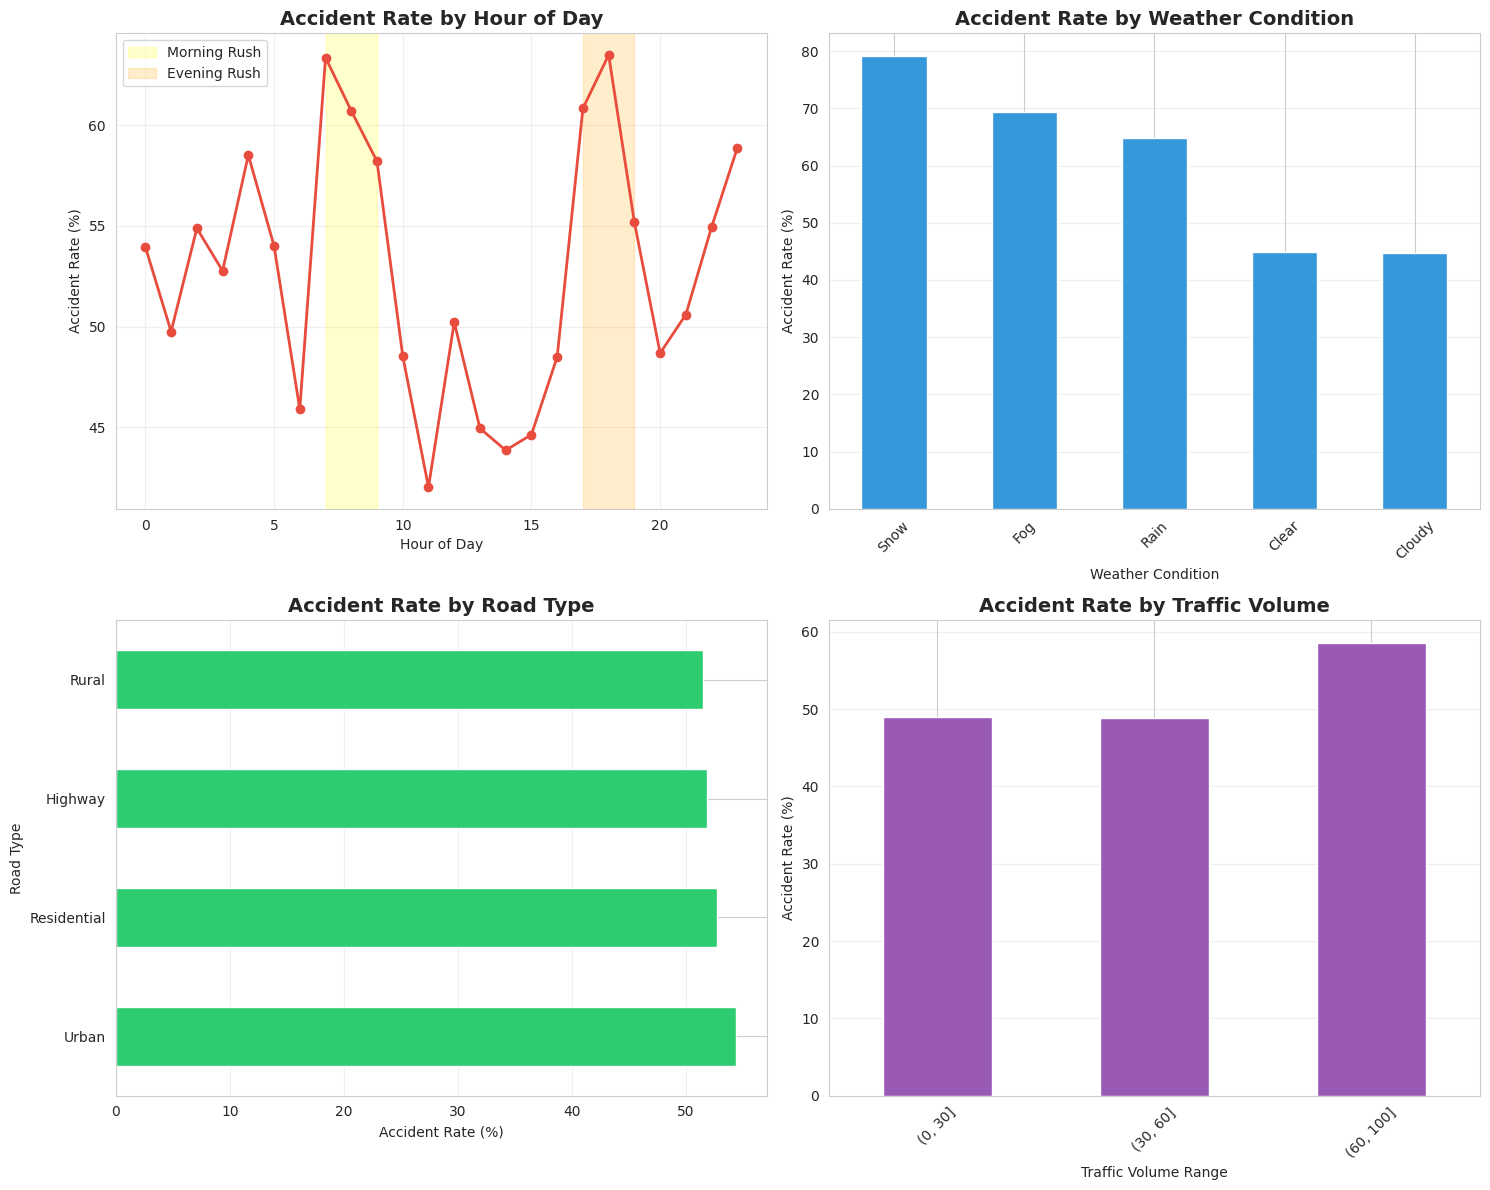

✓ Saved: risk_analysis.png


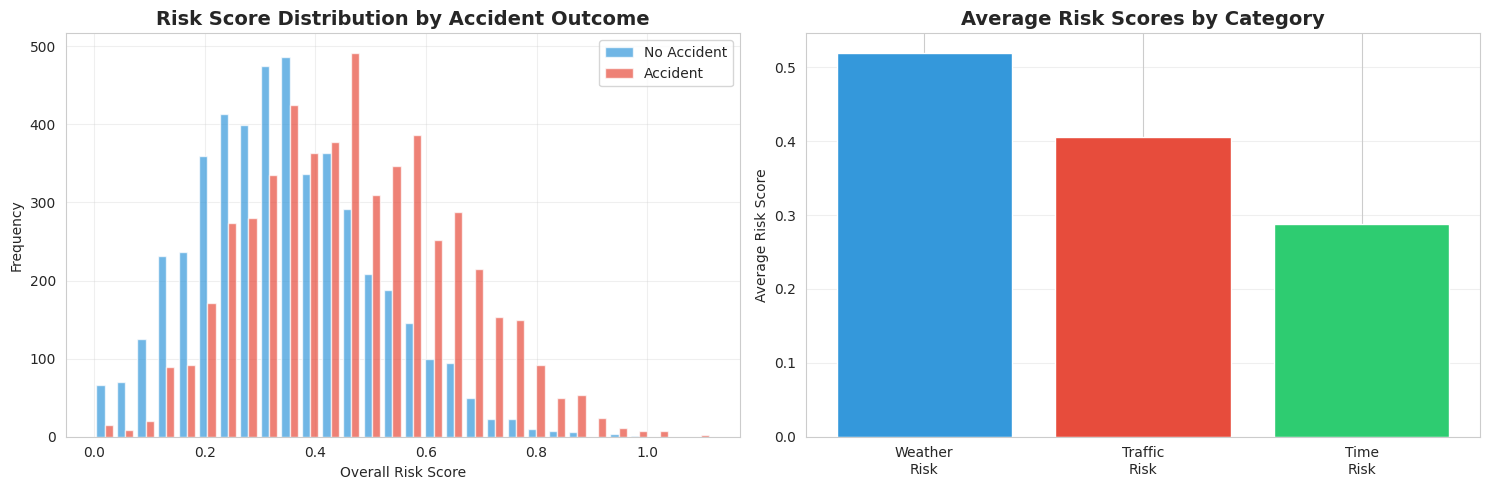


📈 Generating correlation heatmap...
✓ Saved: correlation_heatmap.png


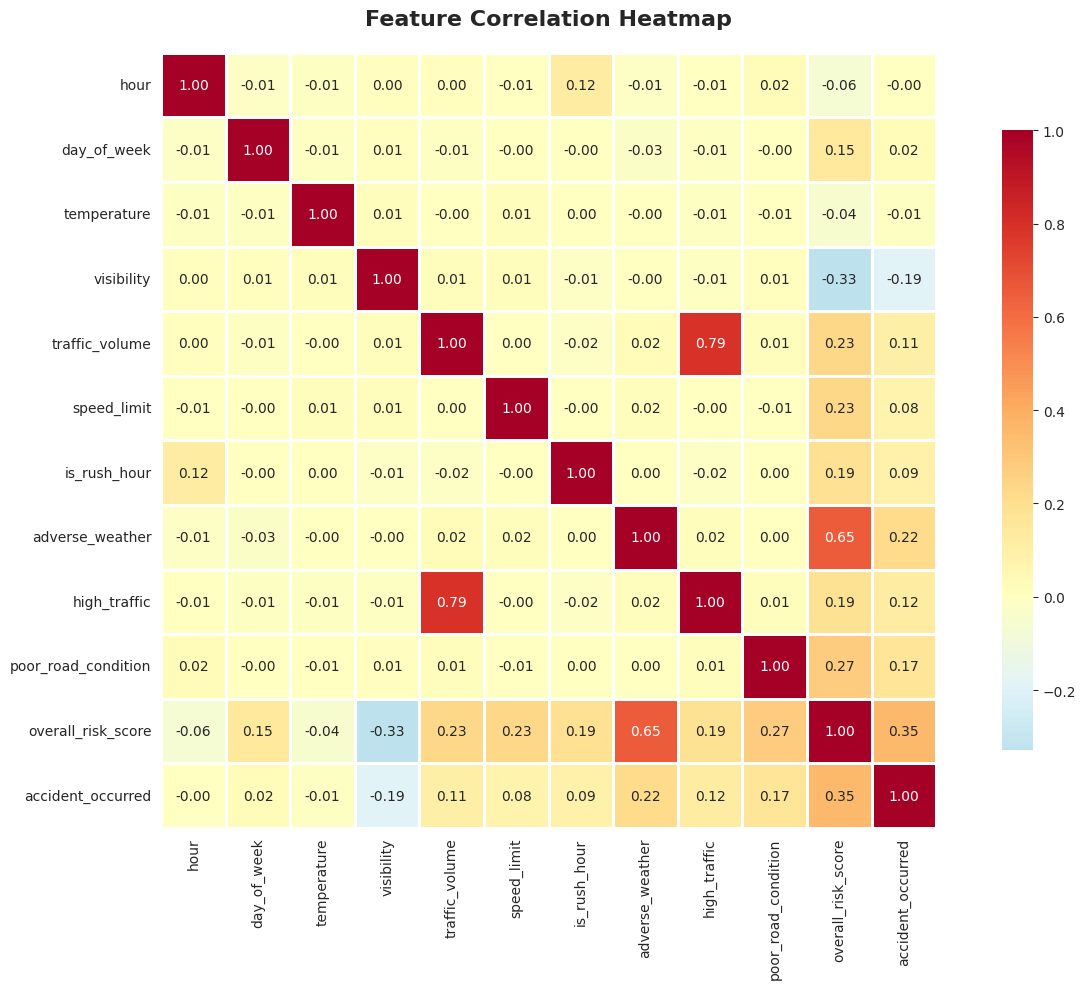

In [ ]:
print("\n" + "="*70)
print("PHASE 5: EXPLORATORY DATA ANALYSIS")
print("="*70)

print("\n📊 Generating visualizations...\n")

# 1. Accident Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accidents by hour
hourly_accidents = feature_data.groupby('hour')['accident_occurred'].agg(['sum', 'count', 'mean'])
axes[0, 0].plot(hourly_accidents.index, hourly_accidents['mean'] * 100, marker='o', linewidth=2, color='#e74c3c')
axes[0, 0].axvspan(7, 9, alpha=0.2, color='yellow', label='Morning Rush')
axes[0, 0].axvspan(17, 19, alpha=0.2, color='orange', label='Evening Rush')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Accident Rate (%)')
axes[0, 0].set_title('Accident Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accidents by weather
weather_accidents = feature_data.groupby('weather')['accident_occurred'].mean() * 100
weather_accidents.sort_values(ascending=False).plot(kind='bar', ax=axes[0, 1], color='#3498db')
axes[0, 1].set_xlabel('Weather Condition')
axes[0, 1].set_ylabel('Accident Rate (%)')
axes[0, 1].set_title('Accident Rate by Weather Condition', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Accidents by road type
road_accidents = feature_data.groupby('road_type')['accident_occurred'].mean() * 100
road_accidents.sort_values(ascending=False).plot(kind='barh', ax=axes[1, 0], color='#2ecc71')
axes[1, 0].set_xlabel('Accident Rate (%)')
axes[1, 0].set_ylabel('Road Type')
axes[1, 0].set_title('Accident Rate by Road Type', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Traffic volume vs accidents
traffic_bins = pd.cut(feature_data['traffic_volume'], bins=[0, 30, 60, 100])
traffic_acc = feature_data.groupby(traffic_bins)['accident_occurred'].mean() * 100
traffic_acc.plot(kind='bar', ax=axes[1, 1], color='#9b59b6')
axes[1, 1].set_xlabel('Traffic Volume Range')
axes[1, 1].set_ylabel('Accident Rate (%)')
axes[1, 1].set_title('Accident Rate by Traffic Volume', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('accident_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: accident_analysis.png")
plt.show()

# 2. Risk Score Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall risk score distribution
risk_accident = feature_data[feature_data['accident_occurred'] == 1]['overall_risk_score']
risk_no_accident = feature_data[feature_data['accident_occurred'] == 0]['overall_risk_score']

axes[0].hist([risk_no_accident, risk_accident], bins=30, label=['No Accident', 'Accident'],
             color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_xlabel('Overall Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Risk Score Distribution by Accident Outcome', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Risk scores comparison
risk_scores = feature_data[['weather_risk_score', 'traffic_risk_score', 'time_risk_score']].mean()
axes[1].bar(range(len(risk_scores)), risk_scores.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_xticks(range(len(risk_scores)))
axes[1].set_xticklabels(['Weather\nRisk', 'Traffic\nRisk', 'Time\nRisk'])
axes[1].set_ylabel('Average Risk Score')
axes[1].set_title('Average Risk Scores by Category', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('risk_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: risk_analysis.png")
plt.show()

# 3. Correlation Heatmap
print("\n📈 Generating correlation heatmap...")
correlation_features = ['hour', 'day_of_week', 'temperature', 'visibility', 'traffic_volume',
                        'speed_limit', 'is_rush_hour', 'adverse_weather', 'high_traffic',
                        'poor_road_condition', 'overall_risk_score', 'accident_occurred']

plt.figure(figsize=(14, 10))
corr_matrix = feature_data[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: correlation_heatmap.png")
plt.show()


PHASE 6: MACHINE LEARNING MODEL TRAINING

🔧 Preparing data for modeling...

✓ Features prepared: 26 features
✓ Total samples: 10000
✓ Accident cases: 5289 (52.89%)
✓ Non-accident cases: 4711 (47.11%)

✓ Train set: 8000 samples
✓ Test set: 2000 samples

⚖️  Handling class imbalance with SMOTE...
✓ Balanced train set: 8462 samples
  - Accident cases: 4231
  - Non-accident cases: 4231

📏 Scaling features...
✓ Feature scaling complete

🤖 TRAINING MULTIPLE MODELS

Training: Logistic Regression
⏳ Training in progress...
✓ Training complete

📊 Performance Metrics:
   Accuracy:  0.6715 (67.15%)
   Precision: 0.6869
   Recall:    0.6966
   F1-Score:  0.6917
   AUC-ROC:   0.7376

📋 Detailed Classification Report:
              precision    recall  f1-score   support

 No Accident       0.65      0.64      0.65       942
    Accident       0.69      0.70      0.69      1058

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg  

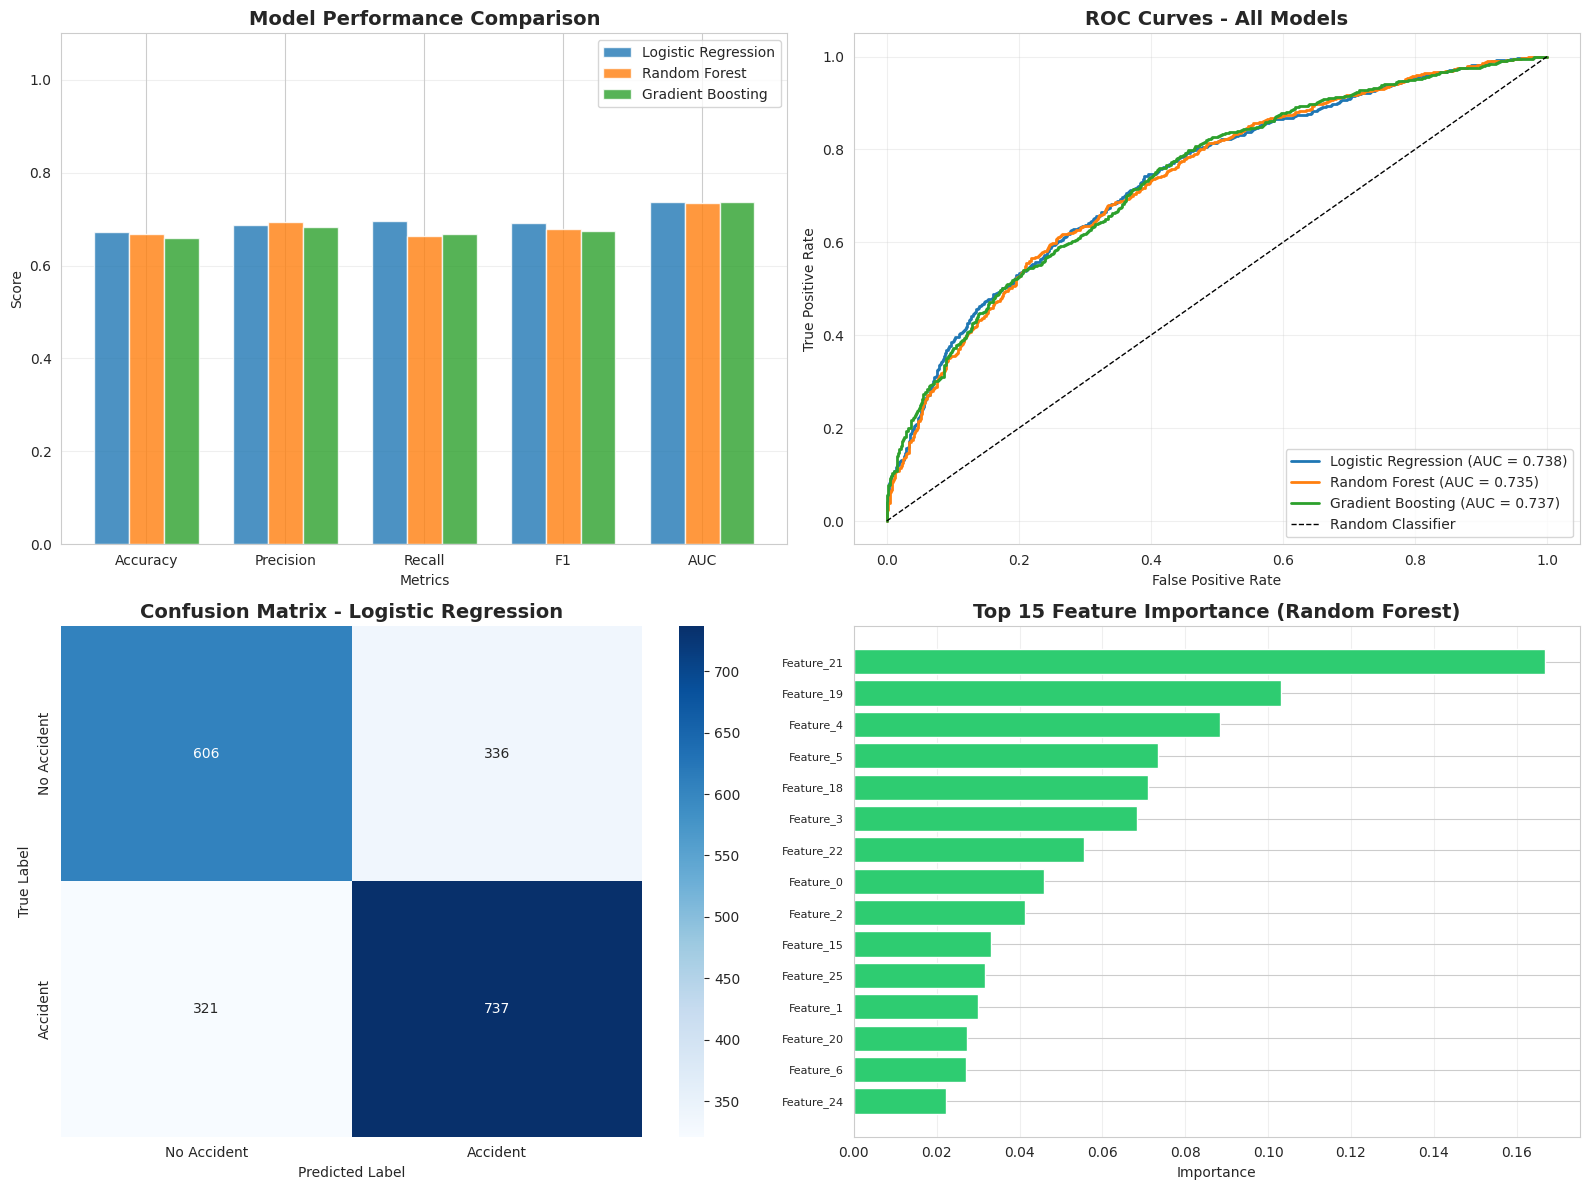


💾 Saving models and artifacts...

✓ Saved best model: Logistic Regression
✓ Saved feature scaler
✓ Saved label encoders
✓ Saved model results summary


In [ ]:
print("\n" + "="*70)
print("PHASE 6: MACHINE LEARNING MODEL TRAINING")
print("="*70)

class MLPipeline:
    """Complete ML pipeline for accident prediction"""

    def __init__(self, df):
        self.df = df
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = None
        self.label_encoders = {}

    def prepare_data(self):
        """Prepare data for modeling"""
        print("\n🔧 Preparing data for modeling...\n")


        numeric_features = [
            'hour', 'day_of_week', 'month', 'temperature', 'visibility',
            'traffic_volume', 'speed_limit', 'construction_zone', 'school_zone',
            'is_rush_hour', 'is_night', 'is_weekend', 'low_visibility',
            'high_traffic', 'high_speed_zone', 'poor_road_condition',
            'is_highway', 'is_urban', 'weather_risk_score', 'traffic_risk_score',
            'time_risk_score', 'overall_risk_score'
        ]

        categorical_features = ['weather', 'road_type', 'road_condition', 'lighting']

        # Encode categorical variables
        df_encoded = self.df.copy()
        for col in categorical_features:
            le = LabelEncoder()
            df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
            self.label_encoders[col] = le
            numeric_features.append(col + '_encoded')

        # Prepare X and y
        X = df_encoded[numeric_features]
        y = df_encoded['accident_occurred']

        print(f"✓ Features prepared: {X.shape[1]} features")
        print(f"✓ Total samples: {len(X)}")
        print(f"✓ Accident cases: {y.sum()} ({y.mean()*100:.2f}%)")
        print(f"✓ Non-accident cases: {len(y) - y.sum()} ({(1-y.mean())*100:.2f}%)")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"\n✓ Train set: {len(X_train)} samples")
        print(f"✓ Test set: {len(X_test)} samples")

        # Handle class imbalance with SMOTE
        print("\n⚖️  Handling class imbalance with SMOTE...")
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        print(f"✓ Balanced train set: {len(X_train_balanced)} samples")
        print(f"  - Accident cases: {y_train_balanced.sum()}")
        print(f"  - Non-accident cases: {len(y_train_balanced) - y_train_balanced.sum()}")

        # Scale features
        print("\n📏 Scaling features...")
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train_balanced)
        X_test_scaled = self.scaler.transform(X_test)

        print("✓ Feature scaling complete")

        return X_train_scaled, X_test_scaled, y_train_balanced, y_test, numeric_features

    def train_models(self, X_train, X_test, y_train, y_test):
        """Train multiple models"""
        print("\n" + "="*70)
        print("🤖 TRAINING MULTIPLE MODELS")
        print("="*70)

        # Define models
        models_to_train = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                                    random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5,
                                                           random_state=42)
        }

        # Train and evaluate each model
        for name, model in models_to_train.items():
            print(f"\n{'='*70}")
            print(f"Training: {name}")
            print(f"{'='*70}")

            # Train
            print("⏳ Training in progress...")
            model.fit(X_train, y_train)
            self.models[name] = model
            print("✓ Training complete")

            # Predict
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            # Store results
            self.results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'y_test': y_test
            }

            # Print results
            print(f"\n📊 Performance Metrics:")
            print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
            print(f"   Precision: {precision:.4f}")
            print(f"   Recall:    {recall:.4f}")
            print(f"   F1-Score:  {f1:.4f}")
            print(f"   AUC-ROC:   {auc:.4f}")

            # Classification report
            print(f"\n📋 Detailed Classification Report:")
            print(classification_report(y_test, y_pred,
                                       target_names=['No Accident', 'Accident']))

        # Identify best model
        best_model_name = max(self.results, key=lambda x: self.results[x]['auc'])
        self.best_model = self.models[best_model_name]

        print(f"\n{'='*70}")
        print(f"🏆 BEST MODEL: {best_model_name}")
        print(f"   AUC Score: {self.results[best_model_name]['auc']:.4f}")
        print(f"{'='*70}")

        return best_model_name

    def plot_model_comparison(self):
        """Plot model performance comparison"""
        print("\n📊 Generating model comparison plots...\n")

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Metrics Comparison
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
        model_names = list(self.results.keys())

        x = np.arange(len(metrics))
        width = 0.25

        for i, model_name in enumerate(model_names):
            values = [self.results[model_name][m] for m in metrics]
            axes[0, 0].bar(x + i*width, values, width, label=model_name, alpha=0.8)

        axes[0, 0].set_xlabel('Metrics')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
        axes[0, 0].set_xticks(x + width)
        axes[0, 0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        axes[0, 0].set_ylim([0, 1.1])

        # 2. ROC Curves
        for model_name in model_names:
            y_test = self.results[model_name]['y_test']
            y_pred_proba = self.results[model_name]['y_pred_proba']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = self.results[model_name]['auc']
            axes[0, 1].plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

        axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
        axes[0, 1].legend(loc='lower right')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Confusion Matrix for best model
        best_model_name = max(self.results, key=lambda x: self.results[x]['auc'])
        y_test = self.results[best_model_name]['y_test']
        y_pred = self.results[best_model_name]['y_pred']
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                   xticklabels=['No Accident', 'Accident'],
                   yticklabels=['No Accident', 'Accident'])
        axes[1, 0].set_ylabel('True Label')
        axes[1, 0].set_xlabel('Predicted Label')
        axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}',
                            fontsize=14, fontweight='bold')

        # 4. Feature Importance (for Random Forest)
        if 'Random Forest' in self.models:
            rf_model = self.models['Random Forest']
            feature_names = [f'Feature_{i}' for i in range(len(rf_model.feature_importances_))]
            importances = rf_model.feature_importances_
            indices = np.argsort(importances)[-15:]  # Top 15 features

            axes[1, 1].barh(range(len(indices)), importances[indices], color='#2ecc71')
            axes[1, 1].set_yticks(range(len(indices)))
            axes[1, 1].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
            axes[1, 1].set_xlabel('Importance')
            axes[1, 1].set_title('Top 15 Feature Importance (Random Forest)',
                                fontsize=14, fontweight='bold')
            axes[1, 1].grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: model_comparison.png")
        plt.show()

    def save_models(self):
        """Save trained models and artifacts"""
        print("\n💾 Saving models and artifacts...\n")

        # Save best model
        best_model_name = max(self.results, key=lambda x: self.results[x]['auc'])
        with open('best_model.pkl', 'wb') as f:
            pickle.dump(self.best_model, f)
        print(f"✓ Saved best model: {best_model_name}")

        # Save scaler
        with open('scaler.pkl', 'wb') as f:
            pickle.dump(self.scaler, f)
        print("✓ Saved feature scaler")

        # Save label encoders
        with open('label_encoders.pkl', 'wb') as f:
            pickle.dump(self.label_encoders, f)
        print("✓ Saved label encoders")

        # Save results summary
        results_summary = {
            name: {k: v for k, v in metrics.items()
                  if k not in ['y_pred', 'y_pred_proba', 'y_test']}
            for name, metrics in self.results.items()
        }

        with open('model_results.json', 'w') as f:
            json.dump(results_summary, f, indent=2)
        print("✓ Saved model results summary")

# Initialize and run ML pipeline
ml_pipeline = MLPipeline(feature_data)

# Prepare data
X_train, X_test, y_train, y_test, feature_names = ml_pipeline.prepare_data()

# Train models
best_model_name = ml_pipeline.train_models(X_train, X_test, y_train, y_test)

# Plot comparisons
ml_pipeline.plot_model_comparison()

# Save models
ml_pipeline.save_models()



PHASE 7: MODEL DEPLOYMENT & BATCH PREDICTIONS

🔮 Making batch predictions...

✓ Predictions completed for 1000 records

Prediction Summary:
  High Risk:   392 records
  Medium Risk: 444 records
  Low Risk:    164 records

✓ Predictions saved to 'traffic_predictions.csv'

📊 Generating prediction visualizations...

✓ Saved: prediction_analysis.png


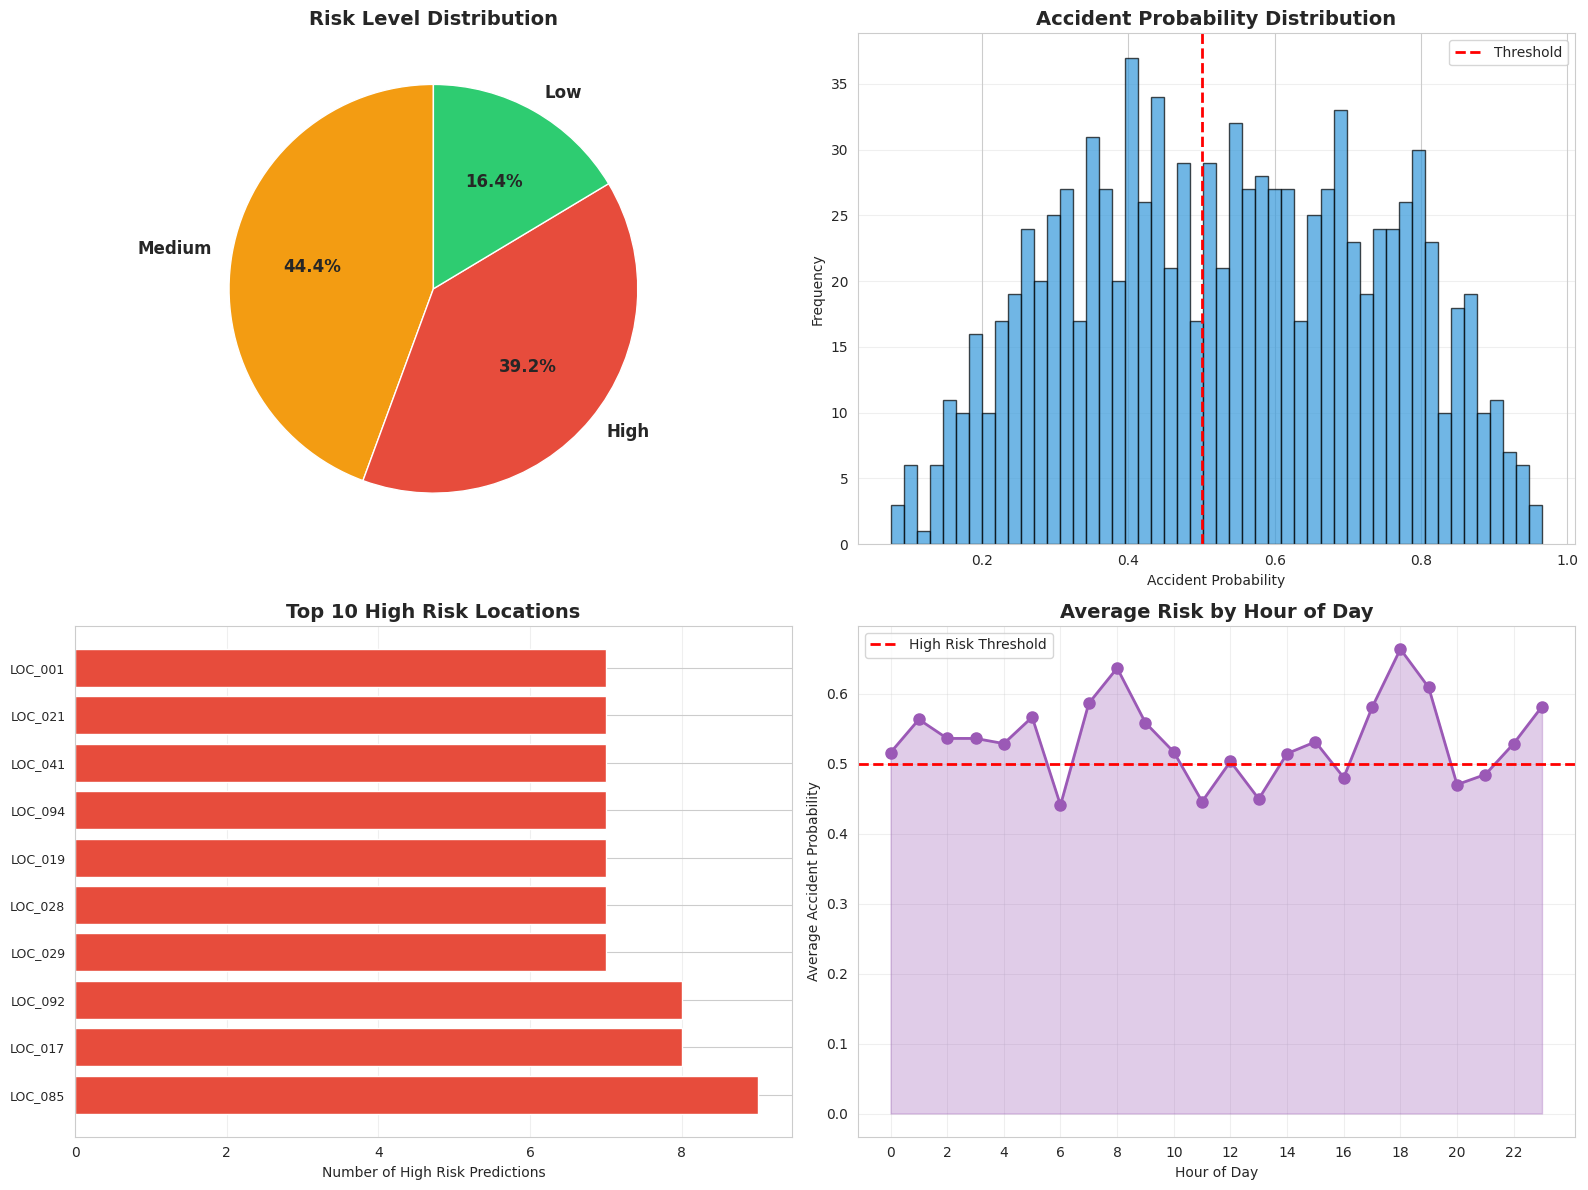

In [ ]:
print("\n" + "="*70)
print("PHASE 7: MODEL DEPLOYMENT & BATCH PREDICTIONS")
print("="*70)

class AccidentPredictor:
    """Production-ready accident prediction system"""

    def __init__(self, model, scaler, label_encoders):
        self.model = model
        self.scaler = scaler
        self.label_encoders = label_encoders
        self.prediction_log = []

    def predict_single(self, input_data):
        """Make prediction for a single record"""
        # This would be used in real-time API
        pass

    def predict_batch(self, df):
        """Make predictions for batch data"""
        print("\n🔮 Making batch predictions...\n")

        # Prepare features (same as training)
        numeric_features = [
            'hour', 'day_of_week', 'month', 'temperature', 'visibility',
            'traffic_volume', 'speed_limit', 'construction_zone', 'school_zone',
            'is_rush_hour', 'is_night', 'is_weekend', 'low_visibility',
            'high_traffic', 'high_speed_zone', 'poor_road_condition',
            'is_highway', 'is_urban', 'weather_risk_score', 'traffic_risk_score',
            'time_risk_score', 'overall_risk_score'
        ]

        categorical_features = ['weather', 'road_type', 'road_condition', 'lighting']

        df_pred = df.copy()

        # Encode categorical variables
        for col in categorical_features:
            if col in self.label_encoders:
                df_pred[col + '_encoded'] = self.label_encoders[col].transform(df_pred[col])
                numeric_features.append(col + '_encoded')

        # Prepare features
        X = df_pred[numeric_features]

        # Scale
        X_scaled = self.scaler.transform(X)

        # Predict
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)[:, 1]

        # Add to dataframe
        df_pred['accident_prediction'] = predictions
        df_pred['accident_probability'] = probabilities
        df_pred['risk_level'] = pd.cut(probabilities,
                                        bins=[0, 0.3, 0.6, 1.0],
                                        labels=['Low', 'Medium', 'High'])

        print(f"✓ Predictions completed for {len(df_pred)} records")
        print(f"\nPrediction Summary:")
        print(f"  High Risk:   {(df_pred['risk_level'] == 'High').sum()} records")
        print(f"  Medium Risk: {(df_pred['risk_level'] == 'Medium').sum()} records")
        print(f"  Low Risk:    {(df_pred['risk_level'] == 'Low').sum()} records")

        return df_pred

# Create predictor
predictor = AccidentPredictor(ml_pipeline.best_model,
                             ml_pipeline.scaler,
                             ml_pipeline.label_encoders)

# Make predictions on test data (or new data)
predictions_df = predictor.predict_batch(feature_data.sample(1000, random_state=42))

# Save predictions
predictions_df.to_csv('traffic_predictions.csv', index=False)
print("\n✓ Predictions saved to 'traffic_predictions.csv'")

# Visualize predictions
print("\n📊 Generating prediction visualizations...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk Level Distribution
risk_counts = predictions_df['risk_level'].value_counts()
colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
axes[0, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
              colors=[colors[level] for level in risk_counts.index],
              startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0, 0].set_title('Risk Level Distribution', fontsize=14, fontweight='bold')

# 2. Probability Distribution
axes[0, 1].hist(predictions_df['accident_probability'], bins=50,
               color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[0, 1].set_xlabel('Accident Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Accident Probability Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. High Risk Locations
high_risk = predictions_df[predictions_df['risk_level'] == 'High']
location_risk = high_risk.groupby('location_id').size().sort_values(ascending=False).head(10)
axes[1, 0].barh(range(len(location_risk)), location_risk.values, color='#e74c3c')
axes[1, 0].set_yticks(range(len(location_risk)))
axes[1, 0].set_yticklabels(location_risk.index, fontsize=9)
axes[1, 0].set_xlabel('Number of High Risk Predictions')
axes[1, 0].set_title('Top 10 High Risk Locations', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Risk by Time of Day
hourly_risk = predictions_df.groupby('hour')['accident_probability'].mean()
axes[1, 1].plot(hourly_risk.index, hourly_risk.values, marker='o',
               linewidth=2, color='#9b59b6', markersize=8)
axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
axes[1, 1].fill_between(hourly_risk.index, hourly_risk.values, alpha=0.3, color='#9b59b6')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Accident Probability')
axes[1, 1].set_title('Average Risk by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: prediction_analysis.png")
plt.show()

In [ ]:

print("\n" + "="*70)
print("PHASE 8: PIPELINE MONITORING & REPORTING")
print("="*70)

class PipelineMonitor:
    """Monitor pipeline performance and data quality"""

    def __init__(self):
        self.metrics = {}

    def generate_report(self, raw_data, cleaned_data, feature_data,
                       predictions_df, ml_results):
        """Generate comprehensive pipeline report"""
        print("\n📊 Generating Pipeline Report...\n")

        report = {
            'pipeline_execution': {
                'timestamp': datetime.now().isoformat(),
                'status': 'SUCCESS'
            },
            'data_stats': {
                'raw_records': len(raw_data),
                'cleaned_records': len(cleaned_data),
                'feature_records': len(feature_data),
                'data_retention_rate': f"{len(cleaned_data)/len(raw_data)*100:.2f}%"
            },
            'model_performance': {},
            'predictions': {
                'total_predictions': len(predictions_df),
                'high_risk_count': len(predictions_df[predictions_df['risk_level'] == 'High']),
                'medium_risk_count': len(predictions_df[predictions_df['risk_level'] == 'Medium']),
                'low_risk_count': len(predictions_df[predictions_df['risk_level'] == 'Low'])
            }
        }

        # Add model metrics
        for model_name, metrics in ml_results.items():
            report['model_performance'][model_name] = {
                'accuracy': f"{metrics['accuracy']:.4f}",
                'precision': f"{metrics['precision']:.4f}",
                'recall': f"{metrics['recall']:.4f}",
                'f1_score': f"{metrics['f1_score']:.4f}",
                'auc': f"{metrics['auc']:.4f}"
            }

        # Print report
        print("="*70)
        print("PIPELINE EXECUTION REPORT")
        print("="*70)
        print(f"\n📅 Execution Time: {report['pipeline_execution']['timestamp']}")
        print(f"✅ Status: {report['pipeline_execution']['status']}")

        print(f"\n📊 DATA STATISTICS:")
        print(f"   Raw Records:       {report['data_stats']['raw_records']:,}")
        print(f"   Cleaned Records:   {report['data_stats']['cleaned_records']:,}")
        print(f"   Feature Records:   {report['data_stats']['feature_records']:,}")
        print(f"   Retention Rate:    {report['data_stats']['data_retention_rate']}")

        print(f"\n🤖 MODEL PERFORMANCE:")
        for model_name, metrics in report['model_performance'].items():
            print(f"\n   {model_name}:")
            for metric, value in metrics.items():
                print(f"      {metric.capitalize()}: {value}")

        print(f"\n🔮 PREDICTIONS:")
        print(f"   Total Predictions: {report['predictions']['total_predictions']:,}")
        print(f"   High Risk:         {report['predictions']['high_risk_count']:,}")
        print(f"   Medium Risk:       {report['predictions']['medium_risk_count']:,}")
        print(f"   Low Risk:          {report['predictions']['low_risk_count']:,}")

        # Save report
        with open('pipeline_report.json', 'w') as f:
            json.dump(report, f, indent=2)

        print(f"\n✓ Report saved to 'pipeline_report.json'")

        return report

# Generate final report
monitor = PipelineMonitor()
final_report = monitor.generate_report(
    raw_data, cleaned_data, feature_data,
    predictions_df, ml_pipeline.results
)



PHASE 8: PIPELINE MONITORING & REPORTING

📊 Generating Pipeline Report...

PIPELINE EXECUTION REPORT

📅 Execution Time: 2025-11-05T13:09:19.505656
✅ Status: SUCCESS

📊 DATA STATISTICS:
   Raw Records:       10,000
   Cleaned Records:   10,000
   Feature Records:   10,000
   Retention Rate:    100.00%

🤖 MODEL PERFORMANCE:

   Logistic Regression:
      Accuracy: 0.6715
      Precision: 0.6869
      Recall: 0.6966
      F1_score: 0.6917
      Auc: 0.7376

   Random Forest:
      Accuracy: 0.6675
      Precision: 0.6940
      Recall: 0.6645
      F1_score: 0.6789
      Auc: 0.7346

   Gradient Boosting:
      Accuracy: 0.6600
      Precision: 0.6824
      Recall: 0.6682
      F1_score: 0.6753
      Auc: 0.7371

🔮 PREDICTIONS:
   Total Predictions: 1,000
   High Risk:         392
   Medium Risk:       444
   Low Risk:          164

✓ Report saved to 'pipeline_report.json'


In [ ]:
print("\n" + "="*70)
print("PHASE 9: ACTIONABLE INSIGHTS & RECOMMENDATIONS")
print("="*70)

print("\n🎯 KEY INSIGHTS:\n")

# Insight 1: Most dangerous conditions
high_risk_conditions = predictions_df[predictions_df['risk_level'] == 'High']
print("1️⃣  MOST DANGEROUS CONDITIONS:")
print(f"   • Weather: {high_risk_conditions['weather'].mode()[0]}")
print(f"   • Time: {high_risk_conditions['hour'].mode()[0]}:00 hours")
print(f"   • Road Type: {high_risk_conditions['road_type'].mode()[0]}")
print(f"   • Average Visibility: {high_risk_conditions['visibility'].mean():.1f}%")

# Insight 2: Peak accident hours
accident_by_hour = feature_data.groupby('hour')['accident_occurred'].mean()
peak_hours = accident_by_hour.nlargest(3)
print(f"\n2️⃣  PEAK ACCIDENT HOURS:")
for hour, rate in peak_hours.items():
    print(f"   • {hour}:00 - Accident Rate: {rate*100:.2f}%")

# Insight 3: Weather impact
weather_impact = feature_data.groupby('weather')['accident_occurred'].mean().sort_values(ascending=False)
print(f"\n3️⃣  WEATHER IMPACT RANKING:")
for weather, rate in weather_impact.items():
    print(f"   • {weather}: {rate*100:.2f}% accident rate")

# Insight 4: Top risk locations
top_risk_locations = predictions_df.groupby('location_id')['accident_probability'].mean().nlargest(5)
print(f"\n4️⃣  TOP 5 HIGH RISK LOCATIONS:")
for loc, risk in top_risk_locations.items():
    print(f"   • {loc}: {risk*100:.1f}% average risk")

print(f"\n💡 RECOMMENDATIONS:\n")
print("1. Increase patrol during peak hours (7-9 AM, 5-7 PM)")
print("2. Install additional lighting at high-risk locations")
print("3. Implement speed reduction in adverse weather conditions")
print("4. Deploy real-time warning systems for fog/snow conditions")
print("5. Conduct targeted safety campaigns for identified risk factors")

# ================================================================
# FINAL SUMMARY
# ================================================================

print("\n" + "="*70)
print("🎉 PIPELINE EXECUTION COMPLETE!")
print("="*70)

print("\n📁 Generated Files:")
files_generated = [
    'traffic_data_raw.csv',
    'traffic_data_cleaned.csv',
    'traffic_data_features.csv',
    'traffic_predictions.csv',
    'best_model.pkl',
    'scaler.pkl',
    'label_encoders.pkl',
    'model_results.json',
    'pipeline_report.json',
    'accident_analysis.png',
    'risk_analysis.png',
    'correlation_heatmap.png',
    'model_comparison.png',
    'prediction_analysis.png'
]

for i, file in enumerate(files_generated, 1):
    print(f"   {i:2d}. {file}")


PHASE 9: ACTIONABLE INSIGHTS & RECOMMENDATIONS

🎯 KEY INSIGHTS:

1️⃣  MOST DANGEROUS CONDITIONS:
   • Weather: Rain
   • Time: 19:00 hours
   • Road Type: Urban
   • Average Visibility: 37.5%

2️⃣  PEAK ACCIDENT HOURS:
   • 18:00 - Accident Rate: 63.48%
   • 7:00 - Accident Rate: 63.35%
   • 17:00 - Accident Rate: 60.83%

3️⃣  WEATHER IMPACT RANKING:
   • Snow: 79.15% accident rate
   • Fog: 69.29% accident rate
   • Rain: 64.74% accident rate
   • Clear: 44.94% accident rate
   • Cloudy: 44.72% accident rate

4️⃣  TOP 5 HIGH RISK LOCATIONS:
   • LOC_065: 72.2% average risk
   • LOC_085: 69.1% average risk
   • LOC_011: 67.5% average risk
   • LOC_022: 64.9% average risk
   • LOC_047: 64.3% average risk

💡 RECOMMENDATIONS:

1. Increase patrol during peak hours (7-9 AM, 5-7 PM)
2. Install additional lighting at high-risk locations
3. Implement speed reduction in adverse weather conditions
4. Deploy real-time warning systems for fog/snow conditions
5. Conduct targeted safety campaigns f